Found 2000 files belonging to 5 classes.
Using 1600 files for training.
Found 2000 files belonging to 5 classes.
Using 400 files for validation.
Classes détectées : ['01_02', '03_04', '05_06', '07_08', '09_10']

>>> Phase 1 : Entraînement des nouvelles couches...
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 816ms/step - accuracy: 0.3131 - loss: 1.7622 - val_accuracy: 0.4250 - val_loss: 1.4006
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 931ms/step - accuracy: 0.4863 - loss: 1.2869 - val_accuracy: 0.5425 - val_loss: 1.1687
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 902ms/step - accuracy: 0.5813 - loss: 1.0708 - val_accuracy: 0.5475 - val_loss: 1.0936
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 936ms/step - accuracy: 0.6444 - loss: 0.9377 - val_accuracy: 0.5800 - val_loss: 1.0735
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 846ms/step - accuracy: 0.6850 - loss: 0.8640 - val_accuracy: 0.6000 - val_loss: 1.0415
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 935ms/step - accuracy: 0.7156 - loss: 0.7802 - va

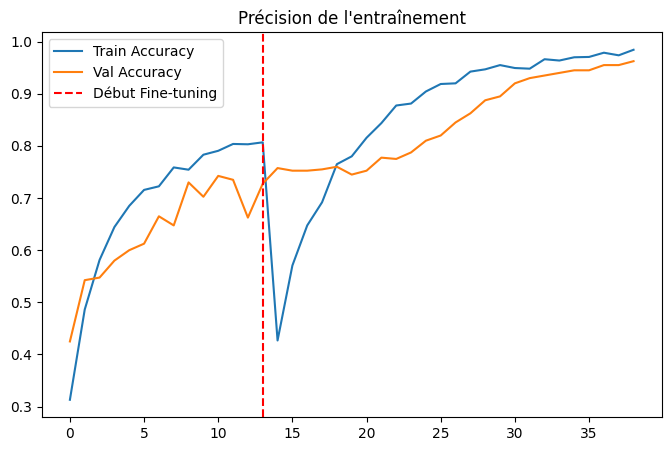

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


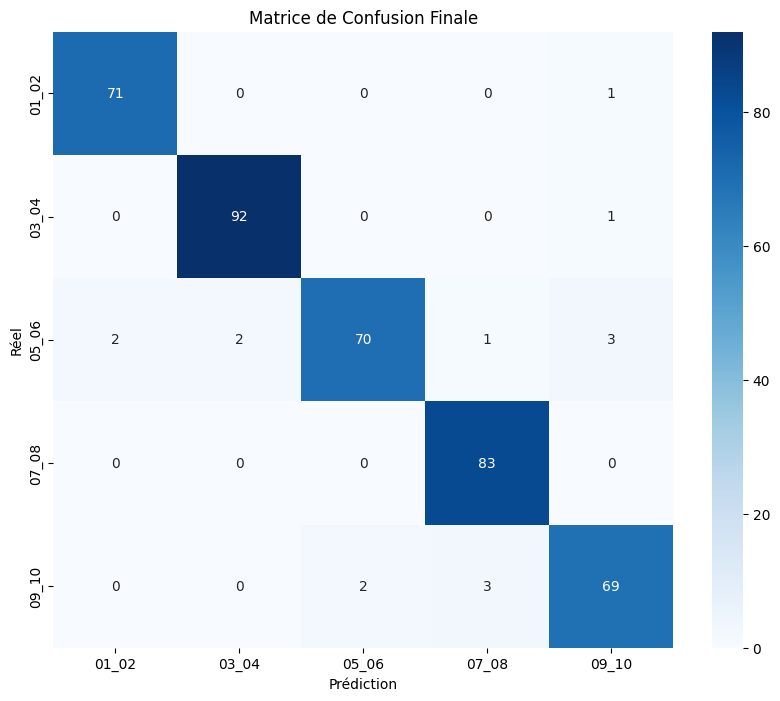


[SUCCÈS] Modèle entraîné et sauvegardé sous 'best_face_model.keras'


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ============================================================
# 1. CONFIGURATION
# ============================================================
DATA_PATH = "big_dataset_lfw"  # Nom de votre dossier
IMG_SIZE = (224, 224)          # Taille optimale pour MobileNetV2
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS_PHASE1 = 15             # Entraînement de la tête
EPOCHS_PHASE2 = 25             # Fine-tuning global

# ============================================================
# 2. CHARGEMENT ET SPLIT (80% Train / 20% Test)
# ============================================================
# Chargement avec gestion automatique du split 80/20
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"Classes détectées : {class_names}")

# Optimisation des performances (mémoire cache + pré-chargement)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ============================================================
# 3. ARCHITECTURE DU MODÈLE (TRANSFER LEARNING)
# ============================================================
# Couche d'augmentation pour renforcer la robustesse
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Base MobileNetV2 pré-entraînée sur ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # On gèle la base au début

# Assemblage du modèle final
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(preprocess_input), # Normalisation auto (-1 à 1)
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),             # Protection contre l'overfitting
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# ============================================================
# 4. PHASE 1 : ENTRAÎNEMENT DE LA TÊTE (Learning Rate élevé)
# ============================================================
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n>>> Phase 1 : Entraînement des nouvelles couches...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# ============================================================
# 5. PHASE 2 : FINE-TUNING (Learning Rate très faible)
# ============================================================
# On débloque les dernières couches du modèle de base pour s'adapter aux visages
base_model.trainable = True
# On ne gèle que les premières couches (les plus génériques)
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), # TRÈS IMPORTANT : LR faible
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n>>> Phase 2 : Fine-Tuning du modèle complet...")
checkpoint = callbacks.ModelCheckpoint("best_face_model.keras", save_best_only=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=[checkpoint, reduce_lr, callbacks.EarlyStopping(patience=5)]
)

# ============================================================
# 6. ÉVALUATION ET MATRICE DE CONFUSION
# ============================================================
def plot_results(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    plt.figure(figsize=(8, 5))
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.axvline(len(h1.history['accuracy'])-1, color='red', linestyle='--', label='Début Fine-tuning')
    plt.title('Précision de l\'entraînement')
    plt.legend()
    plt.show()

plot_results(history, history_fine)

# Matrice de confusion
y_true = []
y_pred = []
for x, y in val_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de Confusion Finale')
plt.show()

print("\n[SUCCÈS] Modèle entraîné et sauvegardé sous 'best_face_model.keras'")

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ============================================================
# 1. SETUP ET CHARGEMENT (80% Train / 20% Test)
# ============================================================
DATA_PATH = "big_dataset_lfw" 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.2, subset="training", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.2, subset="validation", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ============================================================
# 2. DATA AUGMENTATION "FACE-SPECIFIC"
# ============================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1), # Pas plus pour ne pas déformer les visages
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
])

# ============================================================
# 3. ARCHITECTURE DU MODÈLE
# ============================================================
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False 

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(preprocess_input), 
    base_model,
    layers.GlobalMaxPooling2D(), # Changé pour mieux détecter les traits saillants
    layers.Dropout(0.5),         # Augmenté pour contrer l'overfitting
    layers.Dense(5, activation='softmax')
])

# ============================================================
# 4. PHASE 1 : ENTRAÎNEMENT INITIAL (Geler la base)
# ============================================================
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Aide à la généralisation
    metrics=['accuracy']
)

print("\n>>> DÉMARRAGE PHASE 1 (Head Only)")
model.fit(train_ds, validation_data=val_ds, epochs=10)

# ============================================================
# 5. PHASE 2 : FINE-TUNING STABLE (LR très faible)
# ============================================================
# On débloque seulement les 30 dernières couches pour la précision faciale
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# IMPORTANT : On utilise un learning rate 100x plus petit pour éviter la chute de précision
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Callbacks pour un résultat parfait
my_callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.2, patience=3),
    callbacks.ModelCheckpoint("best_facial_model.keras", save_best_only=True)
]

print("\n>>> DÉMARRAGE PHASE 2 (Fine-Tuning)")
model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=my_callbacks)

print("\n[RÉSULTAT] Modèle entraîné et sauvegardé.")

Found 2000 files belonging to 5 classes.
Using 1600 files for training.
Found 2000 files belonging to 5 classes.
Using 400 files for validation.

>>> DÉMARRAGE PHASE 1 (Head Only)
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 921ms/step - accuracy: 0.2244 - loss: 6.7605 - val_accuracy: 0.3475 - val_loss: 2.4062
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 765ms/step - accuracy: 0.3137 - loss: 4.9755 - val_accuracy: 0.3825 - val_loss: 2.7248
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 788ms/step - accuracy: 0.3825 - loss: 4.2879 - val_accuracy: 0.5500 - val_loss: 2.1695
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 643ms/step - accuracy: 0.4313 - loss: 3.6732 - val_accuracy: 0.5000 - val_loss: 2.0922
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 650ms/step - accuracy: 0.4900 - loss: 3.2858 - val_accuracy: 0.5725 - val_loss: 1.8305
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 645ms/step - accuracy: 0.5306 - loss: 2.7972 - val_accuracy: 0.6600 - val_loss: 1.4654
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 660m

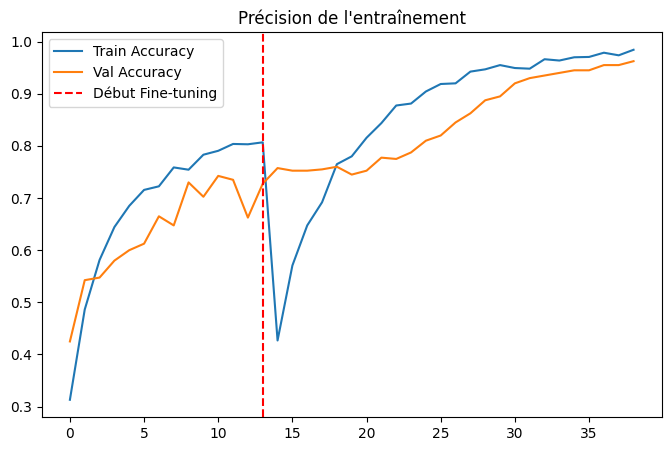

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


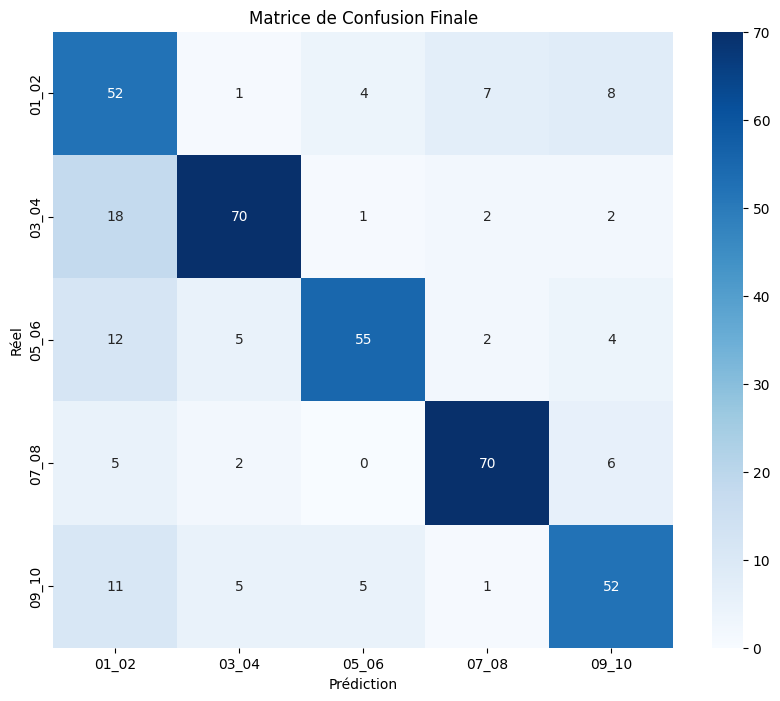


[SUCCÈS] Modèle entraîné et sauvegardé sous 'best_face_model.keras'


In [7]:


# ============================================================
# 6. ÉVALUATION ET MATRICE DE CONFUSION
# ============================================================
def plot_results(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    plt.figure(figsize=(8, 5))
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.axvline(len(h1.history['accuracy'])-1, color='red', linestyle='--', label='Début Fine-tuning')
    plt.title('Précision de l\'entraînement')
    plt.legend()
    plt.show()

plot_results(history, history_fine)

# Matrice de confusion
y_true = []
y_pred = []
for x, y in val_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de Confusion Finale')
plt.show()

print("\n[SUCCÈS] Modèle entraîné et sauvegardé sous 'best_face_model.keras'")

Évaluation en cours...

--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

       01_02       0.53      0.72      0.61        72
       03_04       0.84      0.75      0.80        93
       05_06       0.85      0.71      0.77        78
       07_08       0.85      0.84      0.85        83
       09_10       0.72      0.70      0.71        74

    accuracy                           0.75       400
   macro avg       0.76      0.75      0.75       400
weighted avg       0.77      0.75      0.75       400



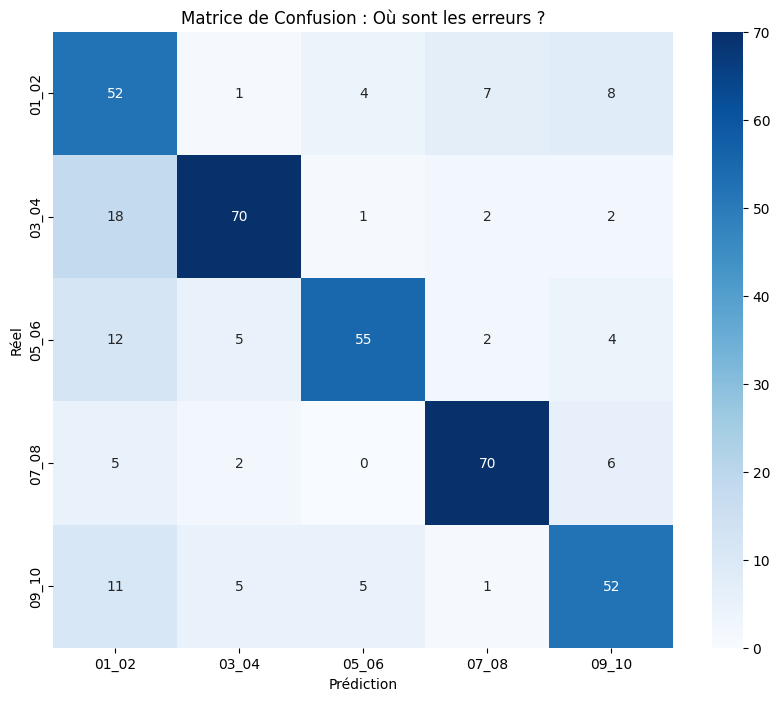

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Récupérer les vrais labels et les prédictions
y_true = []
y_pred = []

print("Évaluation en cours...")
for imgs, labels in val_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Afficher le rapport texte
print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Matrice de confusion visuelle
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion : Où sont les erreurs ?')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Identité : 01_02 (95.40%)


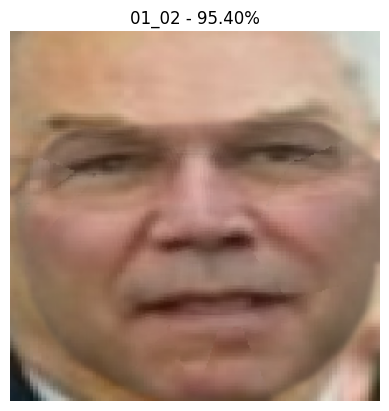

In [9]:
def predict_face(img_path, model, class_names):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Créer un batch de 1
    
    # Prétraitement et Prédiction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    class_idx = np.argmax(predictions[0])
    confidence = 100 * np.max(predictions[0])
    
    print(f"Identité : {class_names[class_idx]} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.title(f"{class_names[class_idx]} - {confidence:.2f}%")
    plt.axis('off')

predict_face("big_dataset_lfw/01_02/morph_lfw_01_02__img_001__img_001__a050_pair01_orig.png", model, class_names)
plt.show()

>>> Lancement du test sur 20 images aléatoires...



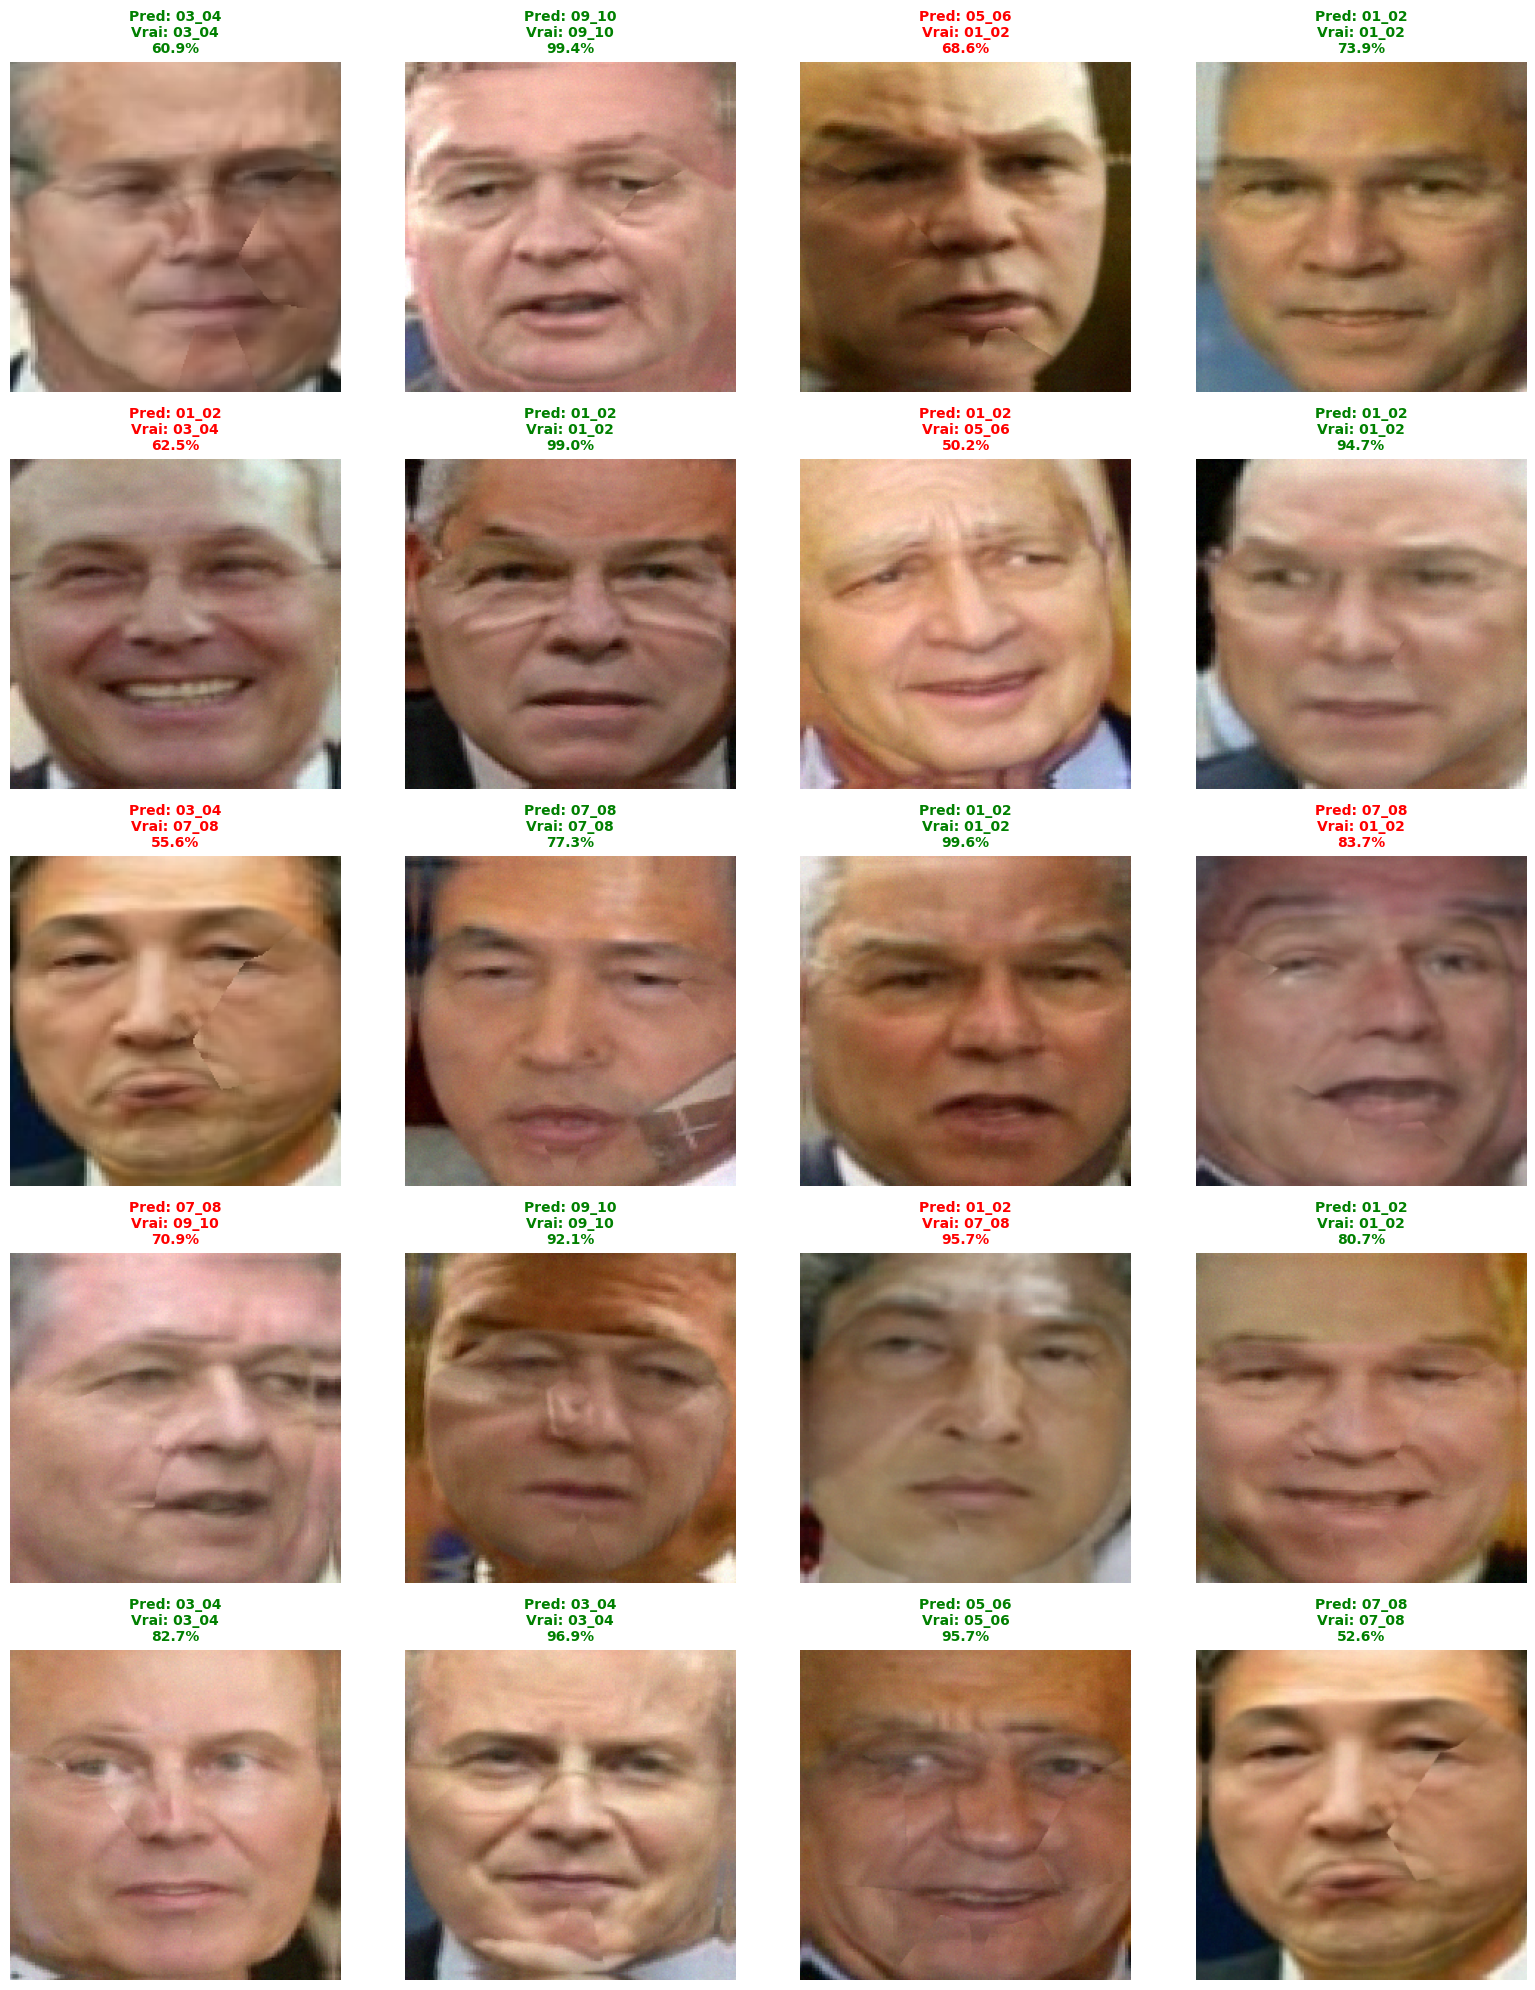

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import os

# 1. Récupérer la liste de toutes les images disponibles dans ton dataset
all_image_paths = []
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_image_paths.append(os.path.join(root, file))

# 2. Sélectionner 20 images au hasard
if len(all_image_paths) < 20:
    print(f"Attention : Seulement {len(all_image_paths)} images trouvées.")
    selected_images = all_image_paths
else:
    selected_images = random.sample(all_image_paths, 20)

# 3. Créer une belle grille (5 lignes x 4 colonnes)
plt.figure(figsize=(16, 20)) # Taille de la figure (Largeur, Hauteur)
print(f">>> Lancement du test sur {len(selected_images)} images aléatoires...\n")

for i, img_path in enumerate(selected_images):
    # A. Préparation de l'image
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    # B. Prédiction (verbose=0 pour cacher la barre de chargement à chaque fois)
    predictions = model.predict(img_array, verbose=0)
    class_idx = np.argmax(predictions[0])
    confidence = 100 * np.max(predictions[0])
    predicted_label = class_names[class_idx]
    
    # C. Récupérer la VRAIE classe (le nom du dossier parent)
    # Ex: big_dataset_lfw/01_02/image.png -> le parent est "01_02"
    true_label = os.path.basename(os.path.dirname(img_path))
    
    # D. Affichage dans la sous-case
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    
    # E. Logique de couleur (Vert = Correct, Rouge = Erreur)
    if predicted_label == true_label:
        color = 'green'
        status = "OK"
    else:
        color = 'red'
        status = "ERREUR"
        
    plt.title(f"Pred: {predicted_label}\nVrai: {true_label}\n{confidence:.1f}%", 
              color=color, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()